# Creating a Dataset out of Real EM Images

The annotations of the real EM images are crudely traced skeletons of fibres and need to be converted into masks and further into the correct dataset formats for fine-tuning.

In [25]:
import os
import cv2 as cv
import numpy as np
from tqdm import tqdm

from src.data_utils import save_label_sam, save_label_yolo

In [26]:
import matplotlib.pyplot as plt

In [27]:
DATASET_1 = '/Users/ab/Documents/AIDS/Bachelors Thesis/Code/data/real datasets/set 1'
DATASET_2 = '/Users/ab/Documents/AIDS/Bachelors Thesis/Code/data/real datasets/set 2'

NEW_DATASET = '/Users/ab/Documents/AIDS/Bachelors Thesis/Code/data/datasets/real_dataset'

100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


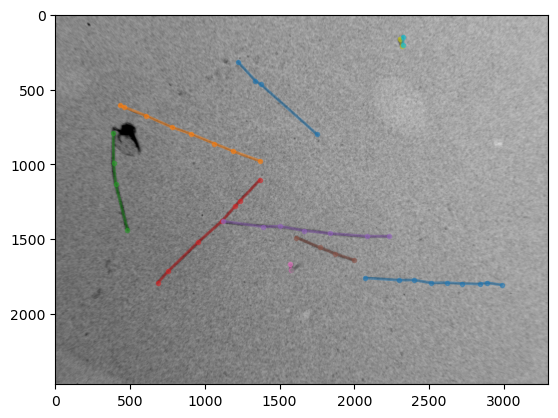

100%|██████████| 64/64 [00:42<00:00,  1.50it/s]


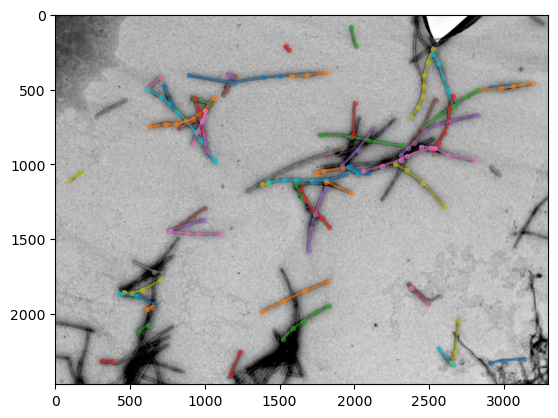

100%|██████████| 349/349 [15:59<00:00,  2.75s/it]


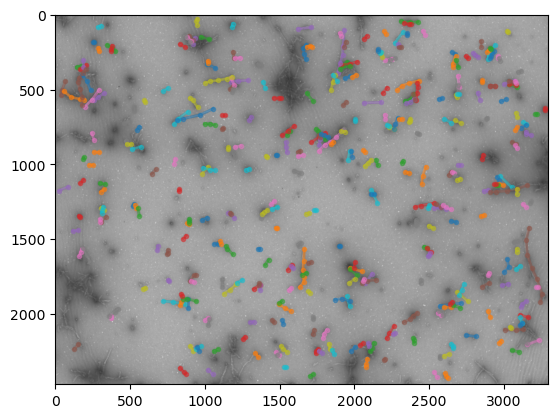

100%|██████████| 316/316 [13:17<00:00,  2.53s/it]


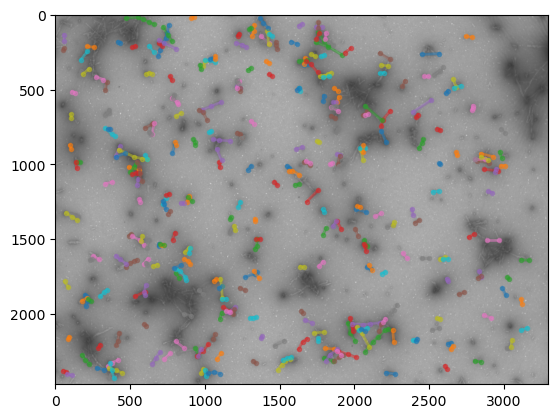

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


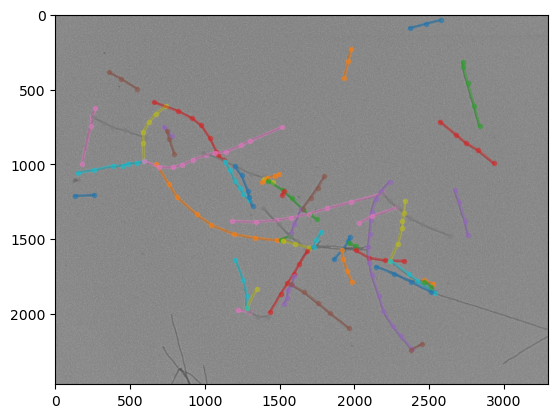

100%|██████████| 207/207 [05:59<00:00,  1.74s/it]


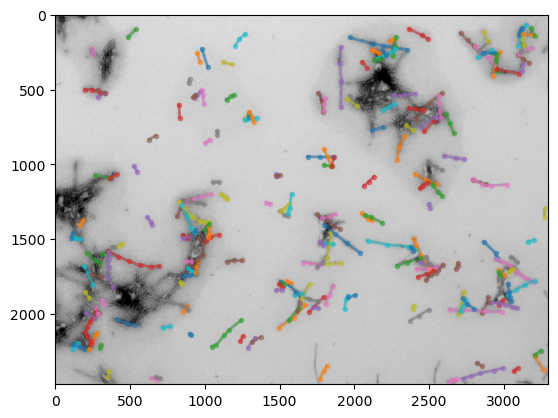

100%|██████████| 160/160 [03:48<00:00,  1.43s/it]


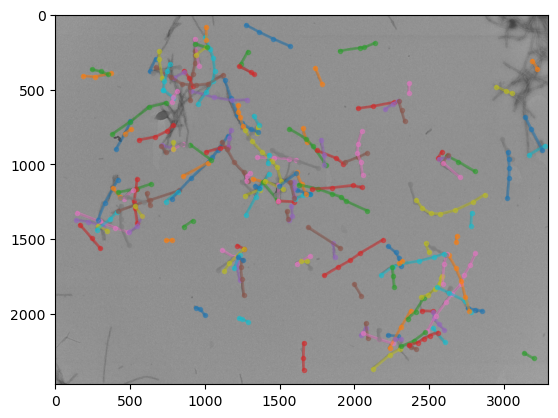

100%|██████████| 127/127 [02:22<00:00,  1.12s/it]


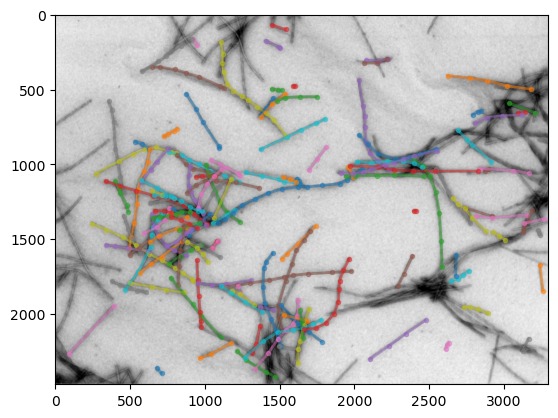

100%|██████████| 205/205 [05:58<00:00,  1.75s/it]


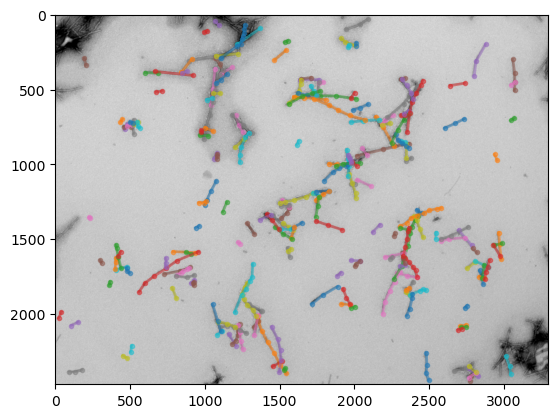

100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


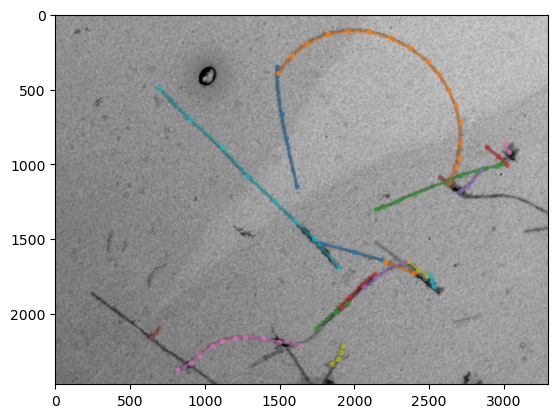

100%|██████████| 140/140 [02:59<00:00,  1.29s/it]


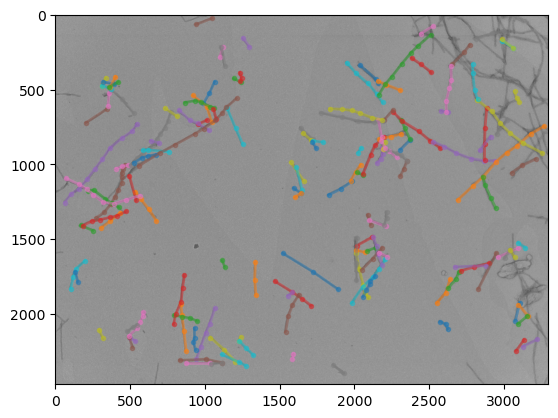

100%|██████████| 11/11 [00:04<00:00,  2.64it/s]


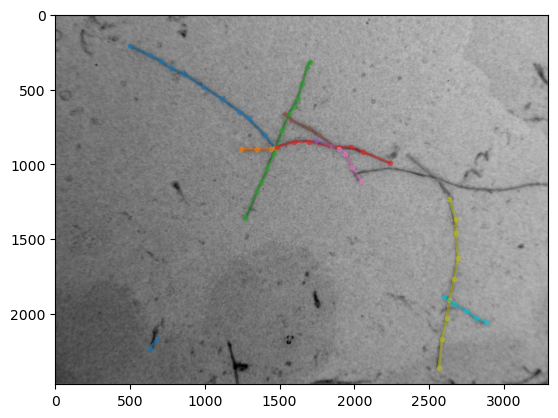

100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


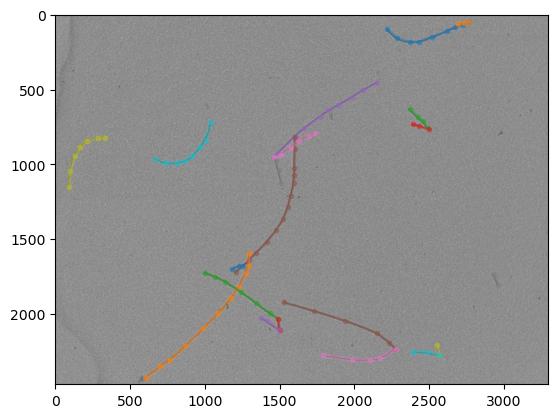

100%|██████████| 161/161 [03:50<00:00,  1.43s/it]


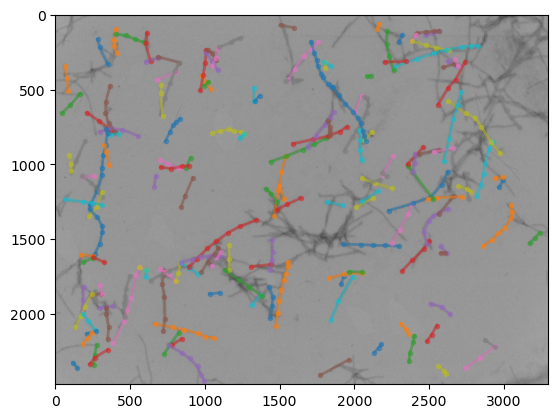

100%|██████████| 174/174 [04:26<00:00,  1.53s/it]


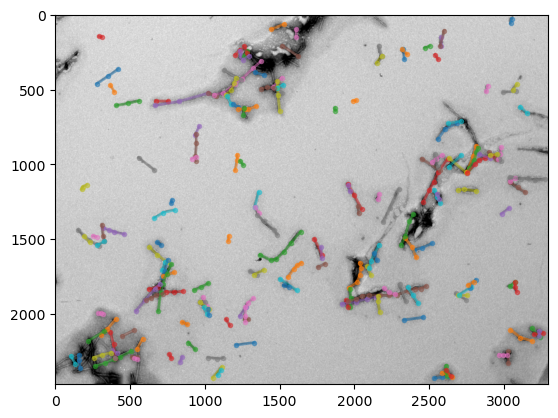

100%|██████████| 41/41 [00:24<00:00,  1.69it/s]


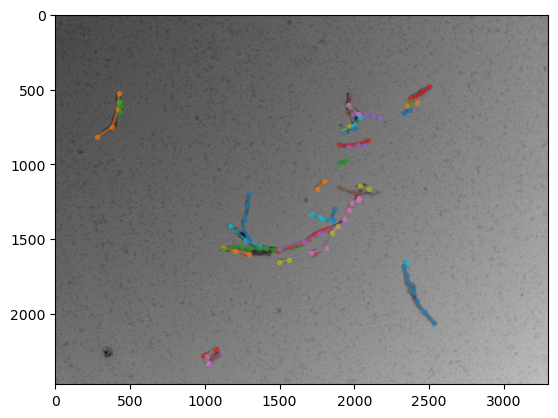

100%|██████████| 133/133 [02:43<00:00,  1.23s/it]


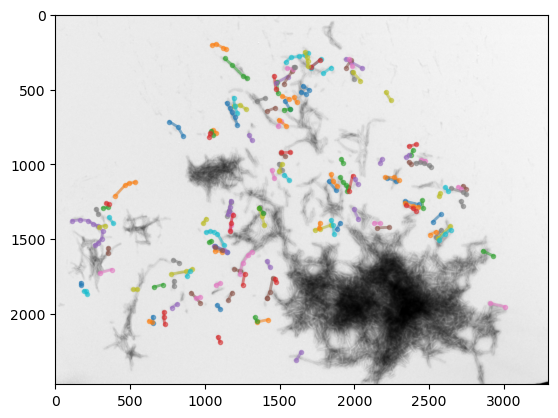

100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


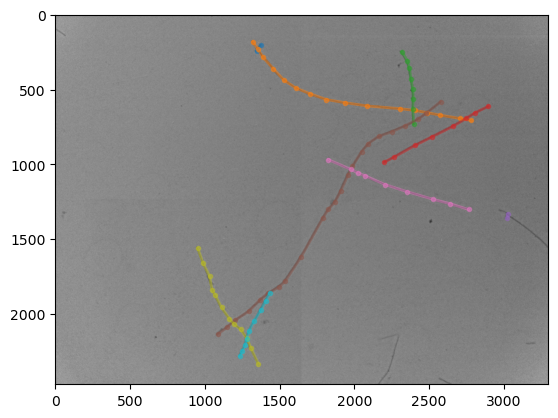

100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


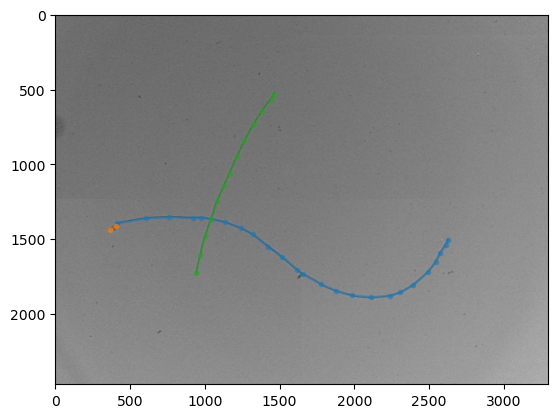

100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


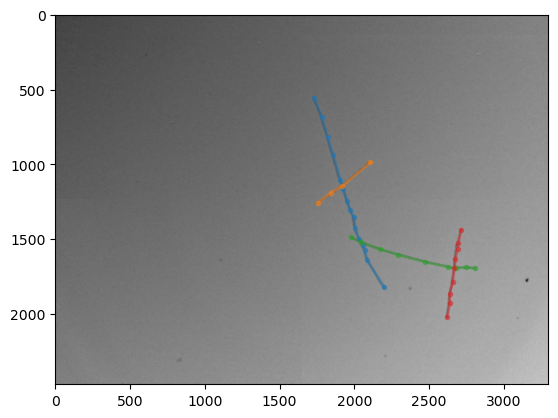

100%|██████████| 106/106 [01:50<00:00,  1.04s/it]


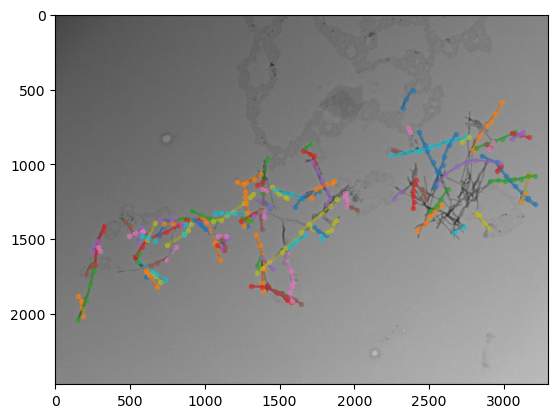

100%|██████████| 37/37 [00:20<00:00,  1.79it/s]


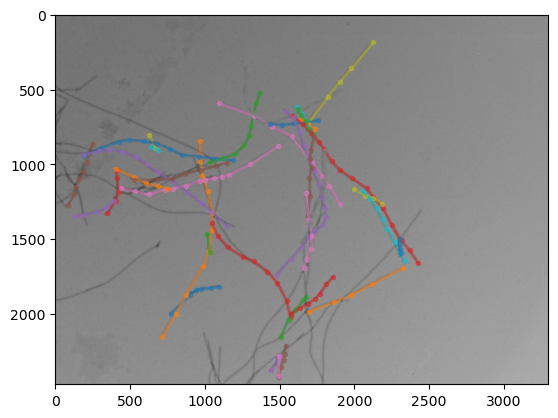

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


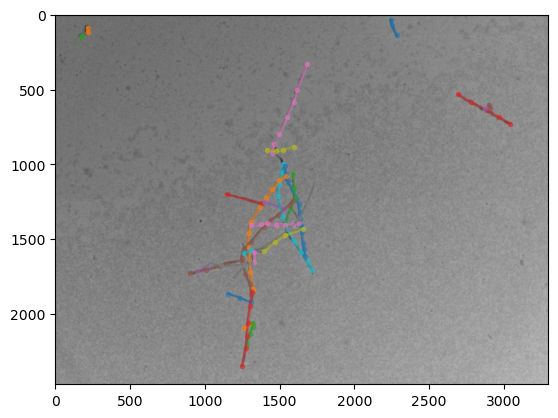

100%|██████████| 355/355 [16:45<00:00,  2.83s/it]


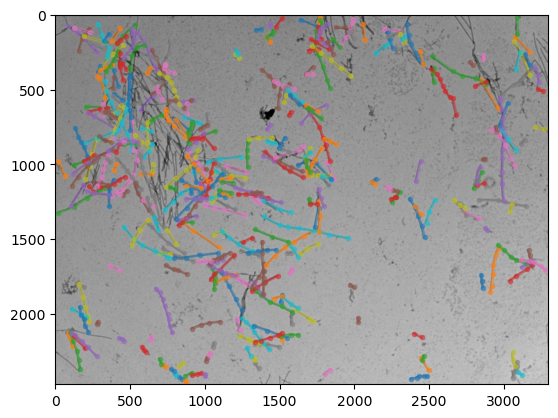

100%|██████████| 142/142 [03:08<00:00,  1.33s/it]


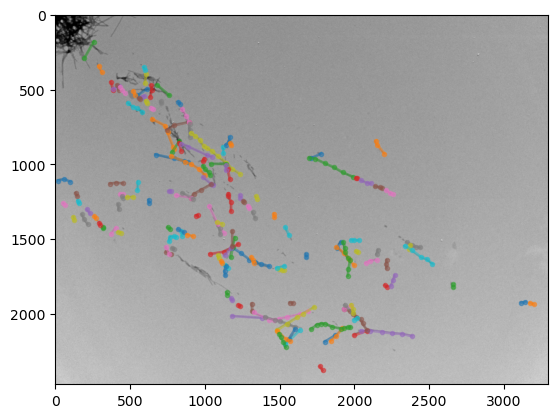

100%|██████████| 29/29 [00:14<00:00,  1.94it/s]


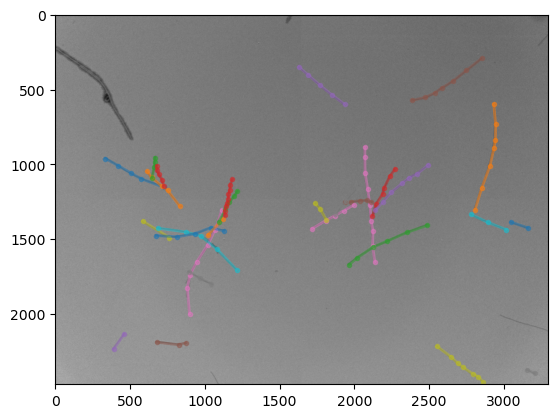

100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


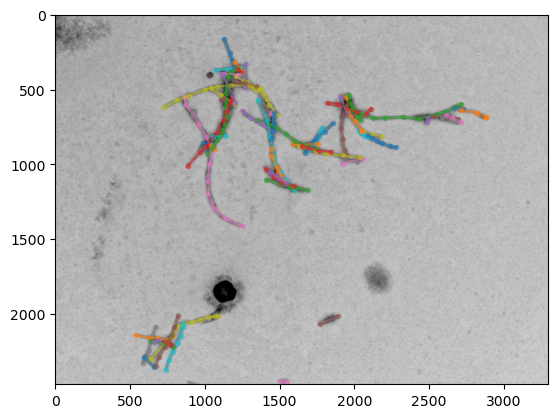

100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


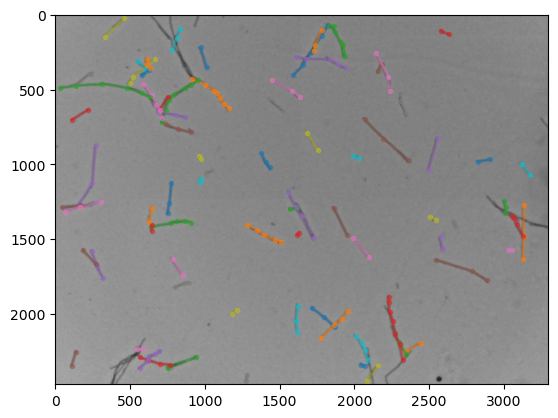

100%|██████████| 34/34 [00:18<00:00,  1.83it/s]


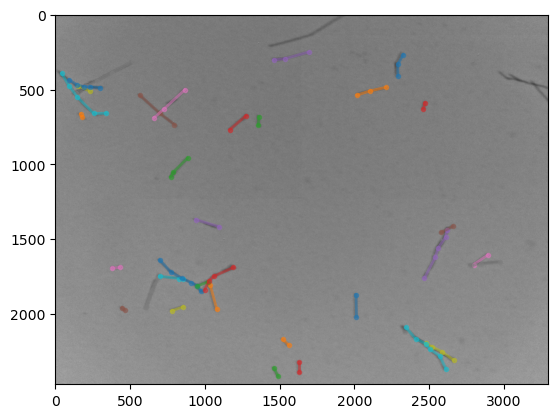

100%|██████████| 41/41 [00:25<00:00,  1.62it/s]


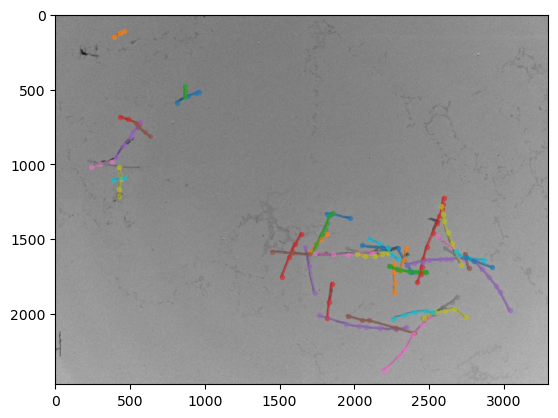

In [28]:
IMAGES = []
LABELS = []
for ds in [DATASET_1, DATASET_2]:
    IMAGE_DIR = os.path.join(ds, 'png files')
    
    for i, imname in enumerate(os.listdir(IMAGE_DIR)):
        if not imname.endswith('.png'):
            continue
        raw_label = os.path.join(ds, 'output/{}.npy'.format(os.path.splitext(imname)[0]))
        impath = os.path.join(IMAGE_DIR, imname)
        
        IMAGES.append(impath)
        LABELS.append(raw_label)
        
        img = cv.imread(impath)
        lbl = np.array(np.load(raw_label, allow_pickle=True)) / 1.765
        # For some reason the labels are not the same size as the image
        for l in lbl:   # Invert Y axis for plotting
            l[:, 1] = np.abs(l[:, 1] - img.shape[0])
        
        # Creating labels
        contours = []
        masks = []
        for l in tqdm(lbl):
            mask = np.zeros(img.shape[:2], np.uint8)
            cv.polylines(mask, [l.astype(np.int32)], isClosed=False, thickness=20, color=255)
            # For saving binary masks for SA1B format
            masks.append(mask)
            
            # For saving COCO format
            contours_data, _ = cv.findContours(mask.astype(np.uint8),
                                               mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
            for contour in contours_data:
                epsilon = 0.003 * cv.arcLength(contour, closed=True)
                approx = cv.approxPolyDP(contour, epsilon=epsilon, closed=True)
                if len(approx) > 2:
                    contours.append(approx)
            
            # Saving labels
            new_imdir = os.path.join(NEW_DATASET, 'images/train')
            new_lbldir = os.path.join(NEW_DATASET, 'labels/train')
            new_imname = f'{imname}_{i+2000}'
            cv.imwrite(os.path.join(new_imdir, f'{new_imname}.png'), img)
            save_label_yolo(new_imname, contours, img.shape[:2], new_lbldir)
            save_label_sam(new_imname, masks, new_imdir)
        
        # PLOTTING
        plt.imshow(img, cmap='gray')
        for l in lbl:
            plt.plot(l[:, 0], l[:, 1], linewidth=2, marker='o', ms=3, alpha=0.5)
        plt.show()
        


# The End.